<div align='center'>
    <h1>Speech Enhancement Using Denoising AutoEncoder</h1>
</div>

<div class='alert alert-warning'>
    <b>This program uses separate directories for training and test data in order to prepare dataset. Please maintain the directory structure as shown below:</b>
</div>

```        
├───speech_denoising_using_dae_v1.0
└───Data
    ├───0 dB
    │   ├───testing
    │   └───training
    └───clean
        ├───testing
        └───training
``` 

In [1]:
# Importing required packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
# Setting the root data directory
data_dir = r'C:\Users\sabbir\Desktop\Desktop Files\DAE\Data'

In [3]:
clean_dir = os.path.join(data_dir, 'clean')
noisy_dir = os.path.join(data_dir, '0 dB')

clean_train_dir = os.path.join(clean_dir, 'training')
clean_test_dir = os.path.join(clean_dir, 'testing')

noisy_train_dir = os.path.join(noisy_dir, 'training')
noisy_test_dir = os.path.join(noisy_dir, 'testing')

#### Let's display two images from clean and noisy directories

In [4]:
clean_img = os.path.join(clean_train_dir, os.listdir(clean_train_dir)[0])
noisy_img = os.path.join(noisy_train_dir, os.listdir(noisy_train_dir)[0])

Text(0, 0.5, 'height')

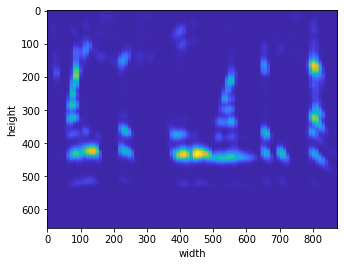

In [5]:
# Displaying images
plt.imshow(imread(clean_img))
plt.xlabel('width')
plt.ylabel('height')

Text(0, 0.5, 'height')

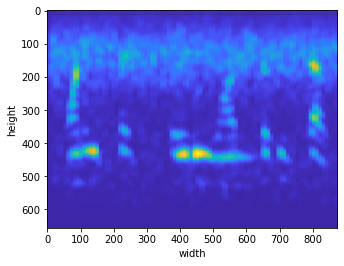

In [6]:
plt.imshow(imread(noisy_img))
plt.xlabel('width')
plt.ylabel('height')

In [7]:
# Checking the shape of image
imread(clean_img).shape

(656, 875, 3)

In [8]:
# Checking the number of cochleagrams for training and testing
print(f'Number of training images are: {len(os.listdir(clean_train_dir))}')
print(f'Number of testing images are: {len(os.listdir(clean_test_dir))}')

Number of training images are: 540
Number of testing images are: 80


<div align='center' class='alert alert-info'>
   <b> As we know that all the cochleagrams are of same size, there is no need of resizing them to a common shape. </b>
</div>

## Preparing the Dataset for Training
- **OpenCV** - to read and reshape cochleagrams and to save as a numpy array
- **tqdm** - to display data loading bar

In [9]:
# Importing required packages
import cv2    # OpenCV
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array

In [10]:
IMAGE_HEIGHT = 512    # CHANGE HERE
IMAGE_WIDTH = 512    # CHANGE HERE
NO_OF_CHANNELs = 3    # CHANGE HERE
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

# Declaring some lists for storing the pixel values of all cochleagrams
clean_train_data = []
clean_test_data = []

noisy_train_data = []
noisy_test_data = []

def convert_image_to_array(datapath, image_size, output_array):
    for file in tqdm(os.listdir(datapath)):
        img = cv2.imread(os.path.join(datapath, file), 1)
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # changing channel order
        output_array.append(img_to_array(img))


convert_image_to_array(clean_train_dir, IMAGE_SIZE, clean_train_data)
convert_image_to_array(clean_test_dir, IMAGE_SIZE, clean_test_data)
convert_image_to_array(noisy_train_dir, IMAGE_SIZE, noisy_train_data)
convert_image_to_array(noisy_test_dir, IMAGE_SIZE, noisy_test_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 98.03it/s]


In [11]:
# Displaying the maximum and minimum pixel values
print(f'Maximum pixel value: {clean_train_data[0].max()}')
print(f'Maximum pixel value: {clean_train_data[0].min()}')

Maximum pixel value: 254.0
Maximum pixel value: 0.0


In [12]:
# Converting the list into numpy array and normalizing the pixel values
clean_train_data = np.asarray(clean_train_data)
clean_train_data = clean_train_data.astype('float32') / 255.

clean_test_data = np.asarray(clean_test_data)
clean_test_data = clean_test_data.astype('float32') / 255.

noisy_train_data = np.asarray(noisy_train_data)
noisy_train_data = noisy_train_data.astype('float32') / 255.

noisy_test_data = np.asarray(noisy_test_data)
noisy_test_data = noisy_test_data.astype('float32') / 255.

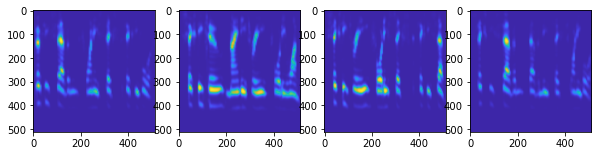

In [13]:
# Displaying clean image
plt.figure(figsize=(10, 8))

for img in range(1, 5):
    ax = plt.subplot(1, 4, img)
    plt.imshow(clean_train_data[img])

plt.show()

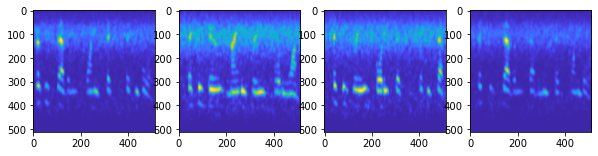

In [14]:
plt.figure(figsize=(10, 8))

for img in range(1, 5):
    ax = plt.subplot(1, 4, img)
    plt.imshow(noisy_train_data[img])

plt.show()

### Building the Network

In [15]:
# Importing required Classes for building the network
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [16]:
KERNEL_SIZE = 3    # KERNEL SIZE
LATENT_DIM = 1408    # DIMENSION OF LATENT VECTOR
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, NO_OF_CHANNELs)    # INPUT IMAGE SHAPE FOR AUTOENCODER
LAYER_FILTERS = [8, 16, 32]    # NUMBER OF FILTERS FOR 3 LAYERS

# Encoder Model
inputs = Input(shape=INPUT_SHAPE, name='encoder_input')
x = inputs 

# Making three convolutional layer based on the number of filters in LAYER_FILTERS
for filters in LAYER_FILTERS:
    x = Conv2D(filters=filters, kernel_size=KERNEL_SIZE, strides=1, activation='relu', padding='same')(x)
    x = MaxPool2D((2, 2))(x)
    

# Saving the shape for decoder
shape = K.int_shape(x)

# Generating the latent vector
x = Flatten()(x)
latent = Dense(LATENT_DIM, name='latent_vector')(x)

# Instantiating the encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0   

In [17]:
# Building the decoder model
latent_inputs = Input(shape=(LATENT_DIM,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Performing Conv2D transpose
for filters in LAYER_FILTERS[::-1]:
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(filters=filters, kernel_size=KERNEL_SIZE, strides=1, activation='relu', padding='same')(x)
    
# Reconstruct the denoised input
outputs = Conv2DTranspose(filters=3, kernel_size=KERNEL_SIZE, activation='sigmoid', padding='same', name='decoder_output')(x)

# Instantiating the decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 1408)]            0         
_________________________________________________________________
dense (Dense)                (None, 131072)            184680448 
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 32)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 32)      9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 16)      4624

In [18]:
# Instantiating the autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 512, 512, 3)]     0         
_________________________________________________________________
encoder (Functional)         (None, 1408)              184556816 
_________________________________________________________________
decoder (Functional)         (None, 512, 512, 3)       184695699 
Total params: 369,252,515
Trainable params: 369,252,515
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
autoencoder.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [20]:
# Defining the values of hyperparameters
BATCH_SIZE = 32
EPOCHS = 10

# Training the model
history = autoencoder.fit(noisy_train_data, 
                          clean_train_data, 
                          validation_data=(noisy_test_data, clean_test_data), 
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE,
                          verbose=2)

Epoch 1/10
17/17 - 214s - loss: 0.6447 - accuracy: 0.5708 - val_loss: 0.5796 - val_accuracy: 0.9790
Epoch 2/10
17/17 - 210s - loss: 0.5590 - accuracy: 0.9808 - val_loss: 0.5562 - val_accuracy: 0.9793
Epoch 3/10
17/17 - 203s - loss: 0.5521 - accuracy: 0.9809 - val_loss: 0.5517 - val_accuracy: 0.9793
Epoch 4/10
17/17 - 210s - loss: 0.5501 - accuracy: 0.9809 - val_loss: 0.5505 - val_accuracy: 0.9793
Epoch 5/10
17/17 - 209s - loss: 0.5497 - accuracy: 0.9809 - val_loss: 0.5504 - val_accuracy: 0.9793
Epoch 6/10
17/17 - 203s - loss: 0.5495 - accuracy: 0.9809 - val_loss: 0.5502 - val_accuracy: 0.9793
Epoch 7/10
17/17 - 211s - loss: 0.5494 - accuracy: 0.9809 - val_loss: 0.5502 - val_accuracy: 0.9793
Epoch 8/10
17/17 - 213s - loss: 0.5494 - accuracy: 0.9809 - val_loss: 0.5501 - val_accuracy: 0.9793
Epoch 9/10
17/17 - 208s - loss: 0.5492 - accuracy: 0.9809 - val_loss: 0.5499 - val_accuracy: 0.9793
Epoch 10/10
17/17 - 200s - loss: 0.5491 - accuracy: 0.9809 - val_loss: 0.5498 - val_accuracy: 0.9793

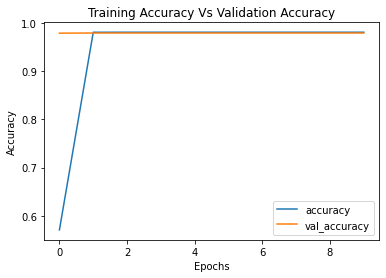

In [21]:
# Converting the history into a pandas dataframe
history_df = pd.DataFrame(history.history)

# Plotting the accuracy curve
history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

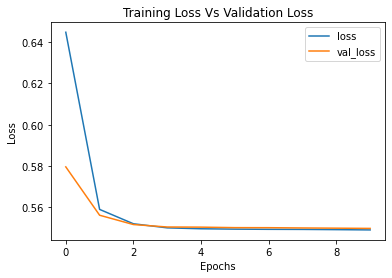

In [22]:
# Plotting the loss curve
history_df[['loss', 'val_loss']].plot()
plt.title('Training Loss Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [23]:
# Prediction on noisy test data
denoised_img = autoencoder.predict(noisy_test_data)

In [24]:
# Importing array_to_img function from keras to convert numpy array to image
from tensorflow.keras.preprocessing.image import array_to_img

In [25]:
# Plotting a denoised cochleagram
x = array_to_img((denoised_img[5] * 255).astype(np.uint8))

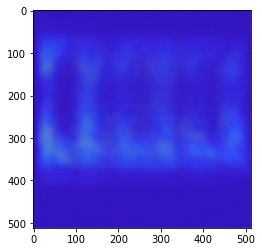

In [26]:
plt.imshow(x)

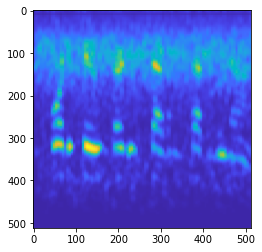

In [27]:
# Plotting the original noisy cochleagram
plt.imshow(array_to_img((noisy_test_data[5] * 255).astype(np.uint8)))

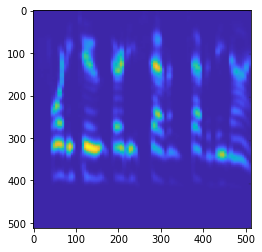

In [28]:
# Plotting the clean cochleagram
plt.imshow(array_to_img((clean_test_data[5] * 255).astype(np.uint8)))